# Dask DataFrame

pandas 已经成为 DataFrame 的标准，但无法利用多核和集群，Dask DataFrame 试图解决 pandas 并行计算的问题。Dask DataFrame 尽量提供与 pandas 一致的 API，但使用起来，Dask DataFrame 仍有很多不同。Dask DataFrame 将大数据切分成小的 Partition，每个 Partition 是一个 pandas DataFrame。Dask 会把 DataFrame 的元数据记录下来，存储在 \_meta 中。多个 Partition 的信息存储在内置变量 partitions 里和 divisions 里。Dask 用 Task Graph 管理计算图。对于用户来说，其实不需要太深入理解 Dask DataFrame 具体如何实现的，只需要调用跟 pandas 类似的上层 API。本章假设用户已经了解并熟悉 pandas，并重点讨论 Dask DataFrame 与 pandas 的区别。

# 读写数据

Dask DataFrame 支持 pandas 中几乎所有的数据读写操作，包括从本地、NFS、HDFS 或 S3 上读写文本文件、Parquet、HDF、JSON 等格式的文件。 下表是几个常见的读写操作。

||CSV|Parquet|HDF
|---|---|---|---|
|读|read_csv()|read_parquet()|read_hdf()
|写|to_csv()|to_parquet()|to_hdf()

## 文件系统

当我们在使用 Dask 集群读写数据时，数据源应该存储在 NFS、HDFS、S3 这种共享文件系统，这样所有 Dask Worker 都能访问该数据。

业内经常使用文件系统前缀（Scheme）来标识不同的文件系统，并调用不同的库来读写文件系统。下表是几个 Scheme 例子。一个数据集地址，应该是一个统一资源标识（Uniform Resource Identifier，URI），URI 包括 Scheme 和具体的地址，URI 模板为：scheme://path/to/data。比如：file:///tmp/tripdata.parquet 或 s3://tmp/tripdata.parquet。

||本地|S3|HDFS
|---|---|---|---|
|Scheme|file://|s3://|hdfs://

如果数据集地址没有加任何 Scheme，会假设是本地可访问的文件系统，即该计算节点可以直接读写和访问的文件系统。比如，网络文件系统（Network File System，NFS）是分布式文件系统，假如被挂载到多个计算节点的 /mnt/nfs 目录，使用 Dask 读写该目录时，可直接使用 /mnt/nfs 这个目录。

HDFS 和 S3 这样共享文件系统，在企业或组织中被多人共享，因此经常有用户验证的环节，以做好用户之间的数据隔离，避免用户互相修改或删除数据。不同的文件系统有自己的用户验证的方式，比如，S3 用户需要提供令牌（Token），Token 可以通过 read_*() 和 to_*() (包括 read_csv()、read_parquet、to_parquet() 等方法) 的 storage_options 参数传递进来。如果你对用户验证不熟悉，应咨询组织中负责运维管理的同事。

## 数据切分与并行读取

### 案例：飞机起降数据

飞机起降数据集由多个逗号分隔的数值（Comma-Separated Values，CSV）文件组成，每个文件对应一个年份，我们读取多个 CSV，来展示 Dask DataFrame 与 pandas 的区别。

In [29]:
import os
import glob

import sys
sys.path.append("..")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

file_path = os.path.join("../../../../data/20.others/nyc_flights/", "nyc-flights", "*.csv")

In [2]:
import dask
dask.config.set({'dataframe.query-planning': False})
import dask.dataframe as dd
import pandas as pd
from dask.distributed import LocalCluster, Client

cluster = LocalCluster()
client = Client(cluster)

pandas 和 Dask DataFrame 都提供了 read_csv() 方法，用来读取 CSV 文件。Dask 的 read_csv() 参数与 pandas 几乎一致，可以参考 pandas 的 read_csv()。比如在这个例子中，原始数据有很多列，其中前三列分别为，年：Year，月：Month，日：DayofMonth，read_csv() 方法的 parse_dates 参数将这三列解析为时间 datetime64 类型，并生成一个新的列 Date。

In [3]:
ddf = dd.read_csv(file_path, parse_dates={'Date': [0, 1, 2]})

这里的 file_path 是 *.csv 的形式，匹配所有以 csv 结尾的文件；而 pandas 的 read_csv() 只能读取单个文件，并不支持 *.csv 这样的通配符。如果想用 pandas 读文件夹下面的所有以 csv 结尾的文件，应该：

In [4]:
file_list = glob.glob(file_path)
data = []

for p in file_list:
    df = pd.read_csv(p, parse_dates={'Date': [0, 1, 2]})
    data.append(df)

pdf = pd.concat(data)

In [5]:
ddf.head(3)

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1991-01-08,2,1215.0,1215,1340.0,1336,US,121,NaN,85.0,...,NaN,4.0,0.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1991-01-09,3,1215.0,1215,1353.0,1336,US,121,NaN,98.0,...,NaN,17.0,0.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1991-01-10,4,1216.0,1215,1332.0,1336,US,121,NaN,76.0,...,NaN,-4.0,1.0,EWR,PIT,319.0,NaN,NaN,0,0


In [6]:
pdf.head(3)

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1991-01-08,2,1215.0,1215,1340.0,1336,US,121,NaN,85.0,...,NaN,4.0,0.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1991-01-09,3,1215.0,1215,1353.0,1336,US,121,NaN,98.0,...,NaN,17.0,0.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1991-01-10,4,1216.0,1215,1332.0,1336,US,121,NaN,76.0,...,NaN,-4.0,1.0,EWR,PIT,319.0,NaN,NaN,0,0


这里体现出 Dask DataFrame 与 pandas 的区别：Dask DataFrame 接受 \*.csv 这样的通配符，可以批量读取文件夹下所有的以 csv 结尾的文件。Dask DataFrame 在实现时，先对 \*.csv 目录进行了遍历，了解到目录下一共有多少个 CSV 文件，并在构建 Task Graph 时，根据文件数量，并行地启动多个 pandas 进程。

ddf.visualize() 将 Task Graph 进行了可视化，可以看到：目录下有 m 个 CSV 文件，在 Task Graph 中生成 m 个 read_csv() 子图，执行时并行地启动 m 个 pandas 的 read_csv()；或者说，每个 CSV 文件对应一个 Partition。根据文件数量构建 Task Graph 中的并行粒度是一种最简单的图生成方式。

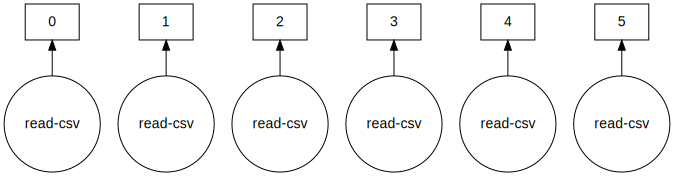

In [7]:
ddf.visualize(filename="../images/nyc-flights-graph", format="svg")

这个例子中，Dask 根据文件数量来确定 Partition 的数量。之前提到，数据切分得过细或者过粗都不是最好的。对于所有可能的场景来说，单纯根据文件数量来确定切分为多少个 Partition 的方式并不一定是最优的：因为如果很多小文件，切分粒度会过细；或者如果是单个大文件，切分粒度过粗，可能导致 OOM。这两种极端情况下生成的 Task Graph 和并行粒度都不是最优的。所以，Dask DataFrame 的 read_csv() 提供了自定义每个 Partition 大小的参数 blocksize，单个 Partition 的大小不会超过 blocksize。如果用户没有显式设置 `blocksize`，Dask DataFrame 会根据探测到的计算资源情况来确定 blocksize，最大不超过 64MB。

## 数据表模式推理

在读取这些数据时，Dask DataFrame 对数据的类型和表模式进行了推测，并将字段名、字段对应的数据类型等表模式记录下来。Dask DataFrame 的 read_csv() 有 sample 的参数，表示只读取前面 sample 字节大小的数据，并根据这些数据来推测数据类型。这会带来问题，应该在最开始读取数据的时候就明确数据类型，而不是依赖 Dask 的表模式推测：

In [7]:
ddf = dd.read_csv(file_path,
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': object,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})
ddf.tail(3)

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
259511,1996-12-29,7,2008.0,1640,2236.0,1852,UA,1659,N424UA,268.0,...,225.0,224.0,208.0,LGA,DEN,1619.0,8.0,35.0,False,0
259512,1996-12-30,1,1644.0,1640,1855.0,1852,UA,1659,N401UA,251.0,...,235.0,3.0,4.0,LGA,DEN,1619.0,5.0,11.0,False,0
259513,1996-12-31,2,1659.0,1640,1902.0,1852,UA,1659,N414UA,243.0,...,216.0,10.0,19.0,LGA,DEN,1619.0,5.0,22.0,False,0


Dask DataFrame 把各个字段的 Schema 放在了 _meta 里，包括字段的名称和类型。

In [8]:
ddf._meta

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted


依然使用刚才的例子，我们加上 blocksize 参数，分别设置为 50_000 和 5_000_000，比较一下不同 Partition 下计算速度，也可以观察 Dask 仪表盘上提供的各类信息。blocksize 为 50_000 时，Task Graph 切分粒度更细，计算图更大，复杂的计算图带来额外开销使得总体耗时更长。

In [9]:
%%time
ddf = dd.read_csv(file_path,
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': object,
                        'CRSElapsedTime': float,
                        'Cancelled': bool},
              blocksize=500_000)

origin_cnt = ddf[~ddf.Cancelled].groupby("Origin").Origin.count().compute()
print(origin_cnt)

Origin
EWR    669254
JFK    255485
LGA    591305
Name: Origin, dtype: int64
CPU times: total: 1.16 s
Wall time: 3.14 s


In [10]:
%%time
ddf = dd.read_csv(file_path, 
                parse_dates={"Date": [0, 1, 2]},
                dtype={"TailNum": str, "CRSElapsedTime": float, "Cancelled": bool},
                blocksize=5_000_000
            )

origin_cnt = ddf[~ddf.Cancelled].groupby("Origin").Origin.count().compute()
print(origin_cnt)

Origin
EWR    669254
JFK    255485
LGA    591305
Name: Origin, dtype: int64
CPU times: total: 531 ms
Wall time: 1.88 s


## Parquet

在大数据工程领域，Apache Parquet 是一种被广泛应用的文件格式。相比 CSV 等纯文本类型文件，Parquet 有以下优势：

- 列式存储

- 内嵌表模式

- 数据压缩

具体而言，列式存储按照列进行存储，而不是 CSV 那样按行存储。数据分析时，我们可能只关心特定的列，而不是所有的列，因此在读取数据时，Parquet 允许很方便地过滤掉不需要的列，而不必读取整个行，即列裁剪（Column Pruning）。除了列裁剪，行裁剪（Row Pruning）是另一种减少数据读取的技术。Parquet 自带了表模式，每个 Parquet 文件里嵌入了每个列的列名、数据类型等元数据，也就避免了 Dask DataFrame 进行表模式推测时推测不准确的问题。Parquet 中的数据是经过压缩的，相比 CSV，Parquet 更节省持久化存储的空间。

Parquet 被广泛应用在 Apache Spark、Apache Hive 和 Apache Flink 等大数据生态。

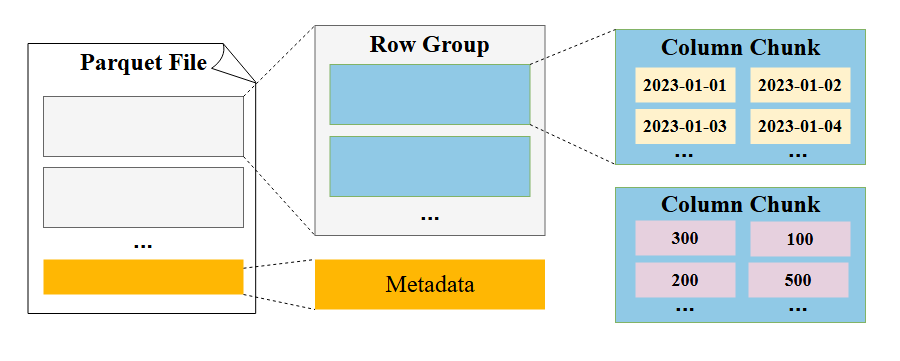

比如，应该尽量读取所需要的列，而不是所有的列。

In [12]:
dd.read_parquet(
    "../data/AirPassengers.parquet",
    columns=["Month"]
)

,Month
npartitions=1,
,object
,...


可以过滤掉不需要的数据：

In [14]:
dd.read_parquet("../data/AirPassengers.parquet", filters=[("Month", ">=", "1949-07")])

,Month
npartitions=1,
,object
,...


# 索引

如下图所示，pandas DataFrame 主要对二维的表进行处理，有列标签和行标签。行标签通常会被用户忽视，但实际上起着至关重要的作用：索引（Indexing）。大多数 pandas DataFrame 的行标签是排好序的索引，比如从 0 开始递增。 这种排好序的索引使得 pandas DataFrame 里面的数据是有序的。

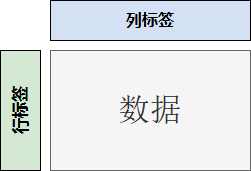

创建 pandas DataFrame 时，会在最左侧自动生成了索引列。从下面的例子可以看出来，索引列没有列名，称不上是一个“字段”，它是在传入数据的字段基础上新增的列。

In [15]:
df = pd.DataFrame({
   'A': ['foo', 'bar', 'baz', 'qux'],
   'B': ['one', 'one', 'two', 'three'],
   'C': [1, 2, 3, 4],
   'D': [10, 20, 30, 40]
})
df

,A,B,C,D
0,foo,one,1,10
1,bar,one,2,20
2,baz,two,3,30
3,qux,three,4,40


也可以设置一个字段作为索引列：

In [16]:
df = df.set_index('A')
df

,B,C,D
A,,,
foo,one,1,10
bar,one,2,20
baz,two,3,30
qux,three,4,40


或者重置回原来的结构：

In [17]:
df = df.reset_index()
df

,A,B,C,D
0,foo,one,1,10
1,bar,one,2,20
2,baz,two,3,30
3,qux,three,4,40


## 有序行索引

Dask DataFrame 由多个 pandas DataFrame 组成，但如何在全局维度维护整个 Dask DataFrame 行标签和行顺序是一个很大的挑战。Dask DataFrame 并没有刻意保留全局有序性，也使得它无法支持所有 pandas DataFrame 的功能。

如下图所示，Dask DataFrame 在切分时有 divisions（分界线）。

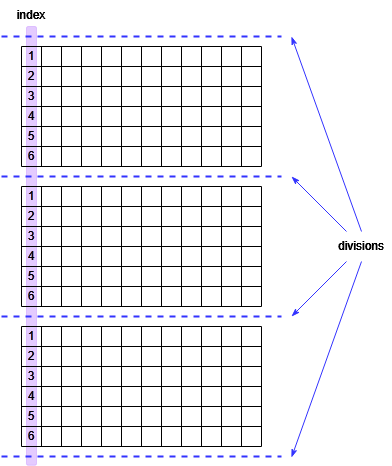

以 Dask 提供的样例数据函数 dask.datasets.timeseries 为例，它生成了时间序列，使用时间戳作为行标签，每个 Partition 的边界都被记录下来，存储在 .divisions 里。len(divisons) 等于 npartitions + 1。

In [18]:
ts_df = dask.datasets.timeseries("2018-01-01", "2023-01-01")
print(f"df.npartitions: {ts_df.npartitions}")
print(f"df.divisions: {len(ts_df.divisions)}")

df.npartitions: 1826
df.divisions: 1827


Dask DataFrame 没有记录每个 Partition 中有多少行，因此无法在全局角度支持基于行索引的操作，比如iloc

In [19]:
try:
    ts_df.iloc[3].compute()
except Exception as e:
    print(f"{type(e).__name__}, {e}")

NotImplementedError, 'DataFrame.iloc' only supports selecting columns. It must be used like 'df.iloc[:, column_indexer]'.


但是可以**支持列标签来选择某些列**；或者**行标签上的 : 通配符选择所有的行**：

In [20]:
ts_df.iloc[:, [1, 2]].compute()

,id,x
timestamp,,
2018-01-01 00:00:00,1013,-0.820125
2018-01-01 00:00:01,939,0.309612
2018-01-01 00:00:02,1000,-0.031801
2018-01-01 00:00:03,1015,-0.070204
2018-01-01 00:00:04,970,0.776383
...,...,...
2022-12-31 23:59:55,1017,-0.248234
2022-12-31 23:59:56,1015,-0.640605
2022-12-31 23:59:57,990,0.444757


因为没有记录每个 Partition 有多少条数据，Dask DataFrame 无法很好地支持一些操作，比如 median() 这样的百分位操作，因为这些操作需要：(1) 对数据排序；(2) 定位到特定的行。

## 设置索引列

### set_index()

在 Dask DataFrame 中，我们可以使用 `set_index()` 方法手动设置某一列为索引列，这个操作除了设置某个字段为索引列，还会根据这个字段对全局数据进行排序，它打乱了原来每个 Partition 的数据排序，因此会有很高的成本。

In [21]:
def print_partitions(ddf):
    for i in range(ddf.npartitions):
        print(ddf.partitions[i].compute())

df = pd.DataFrame(
    {"col1": ["01", "05", "02", "03", "04"], "col2": ["a", "b", "c", "d", "e"]}
)
ddf = dd.from_pandas(df, npartitions=2)
print_partitions(ddf)

  col1 col2
0   01    a
1   05    b
2   02    c
  col1 col2
3   03    d
4   04    e


In [22]:
ddf2 = ddf.set_index("col1")
print_partitions(ddf2)

     col2
col1     
01      a
     col2
col1     
02      c
03      d
04      e
05      b


这个例子设置 col1 列为索引列，2 个 Partition 中的数据被打乱重排。如果是在数据量很大的场景，全局数据排序和重分布的成本极高。因此应该尽量避免这个操作。set_index() 也有它的优势，它可以加速下游的计算。数据重分布又被称为 Shuffle.

回到时间序列数据，该数据使用时间戳作为索引列。下面使用了两种方式对这份数据 set_index()。第一种没有设置 divisions，第二种设置了 divisions。

第一种不设置 divisions 耗时很长，因为 Dask DataFrame 计算了所有 Partiton 的数据分布，并根据分布重排列了所有的 Partition，可以看到，Partition 的数目也发生了变化。

In [23]:
%%time
ts_df1 = ts_df.set_index("id")
nu =  ts_df1.loc[[1001]].name.nunique().compute()
print(f"before set_index npartitions: {ts_df.npartitions}")
print(f"after set_index npartitions: {ts_df1.npartitions}")

before set_index npartitions: 1826
after set_index npartitions: 163
CPU times: total: 27.6 s
Wall time: 1min 22s


第二种方式先提前获取了 divisions，然后将这些 divisions 用于设置 set_index()。设定 division 的 set_index() 速度更快。

In [26]:
dask_computed_divisions = ts_df.set_index("id").divisions
unique_divisions = list(dict.fromkeys(list(dask_computed_divisions)))

In [27]:
%%time
ts_df2 = ts_df.set_index("id", divisions=unique_divisions)
nuids = ts_df2.loc[[1001]].name.nunique().compute()

CPU times: total: 13.2 s
Wall time: 56.5 s


如果不设置索引列，直接对 id 列进行查询，发现反而更快。

In [25]:
%%time
nu = ts_df.loc[ts_df["id"] == 1001].name.nunique().compute()

CPU times: total: 5.89 s
Wall time: 21.1 s


所以 Dask DataFrame 要慎重使用 set_index()，如果 set_index() 之后有很多以下操作，可以考虑使用 set_index()。

- 使用 loc 对索引列进行过滤

- 两个 Dask DataFrame 在索引列上合并（merge()）

- 在索引列上进行分组聚合（groupby()）

### reset_index()

在 pandas 中，groupby 默认 as_index=True，分组字段经过 groupby() 之后成为索引列。索引列在 DataFrame 中并不是“正式”的字段，如果分组聚合之后只有一个“正式”字段（不考虑索引列），分组聚合的结果就成了一个 Series。比如下面 pandas 的例子，Origin 列就是分组字段，如果不设置 as_index=False，groupby("Origin", as_index=False)["DepDelay"].mean() 生成的是一个 Series。

In [31]:
# pandas
file_path = os.path.join('../../../../data/20.others/nyc_flights/nyc-flights/', "1991.csv")
pdf = pd.read_csv(file_path,
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': object,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})
uncancelled_pdf = pdf[pdf["Cancelled"] == False]
avg_pdf = uncancelled_pdf.groupby("Origin", as_index=False)["DepDelay"].mean()
avg_pdf.columns = ["Origin", "AvgDepDelay"]
avg_pdf.sort_values("AvgDepDelay")

,Origin,AvgDepDelay
2,LGA,5.726304
0,EWR,6.916220
1,JFK,9.311532


或者是 reset_index()，来取消索引列，分组字段会成为 DataFrame 的一个正式的字段。

In [32]:
avg_pdf = uncancelled_pdf.groupby("Origin")["DepDelay"].mean().reset_index()
avg_pdf.columns = ["Origin", "AvgDepDelay"]
avg_pdf.sort_values("AvgDepDelay")

,Origin,AvgDepDelay
2,LGA,5.726304
0,EWR,6.916220
1,JFK,9.311532


Dask DataFrame 的 groupby() 不支持 as_index 参数。Dask DataFrame 只能使用 reset_index() 来取消索引列。

# map_partitions

除了3中提到的一些需要通信的计算外，有一种最简单的并行方式，英文术语为 Embarrassingly Parallel，中文可翻译为易并行。它指的是该类计算不需要太多跨 Worker 的协调和通信。比如，对某个字段加一，每个 Worker 内执行加法操作即可，Worker 之间没有通信的开销。Dask DataFrame 中可以使用 map_partitions(func) 来做这类 Embarrassingly Parallel 的操作。map_partitions(func) 的参数是一个 func，这个 func 将在每个 pandas DataFrame 上执行，func 内可以使用 pandas DataFrame 的各类操作。如下图所示，map_partitions(func) 对原来的 pandas DataFrame 进行了转换操作。

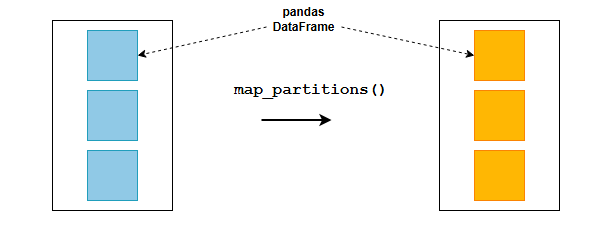

Dask DataFrame 的某些 API 是 Embarrassingly Parallel 的，它的底层就是使用 map_partitions() 实现的。

3.2提到过，Dask DataFrame 会在某个列（索引列）上进行切分，但如果 map_partitions() 对这些索引列做了改动，需要 clear_divisions() 或者重新 set_index()。

In [34]:
ddf.clear_divisions()

,col1,col2
npartitions=2,,
,object,object
,...,...
,...,...


# Shuffle

对于一个分布式系统，在不同 Worker 之间交换数据被称为 Shuffle，或者说 Shuffle 将数据从某个 Partition 移动到其他 Partition。有些 Shuffle 是显式的，比如 repartition，从 API 名称可以看出它会在不同的 Partition 之间交换数据；有些 Shuffle 是隐式的，比如 sort，merge 或 groupby 背后都有 Shuffle 过程。Shuffle 一直是分布式大数据计算领域的难题之一，像 sort、merge 或 groupby 这些 pandas 算子在单机上实现起来相对简单，但是在大数据分布式计算场景，实现起来并不那么容易。

## Shuffle 实现机制

之前介绍了 Dask 主要基于 Task Graph 构建， Dask 的 Task Graph 是一个有向无环图。有向边表示下游 Partition 的输入依赖上游 Partition 的输出，任何数据移动都会在 Task Graph 上生成一条有向边。很多计算任务的 Shuffle 有大量的数据移动，有的场景下，所有数据都会打散，也意味着上游会有多条指向下游的边。这种基于 Task Graph 的 Shuffle 会使得 Task Graph 非常庞大，Task Graph 过大会使得 Dask Scheduler 的负载过重，进一步导致计算极其缓慢。如 图左侧所示，tasks 是基于 Task Graph 的机制，上游和下游之间建立了有向边，如果有中间层（通常因为上游流入的数据太大，需要将数据进一步切分成多个 Partition），那么中间层还会进一步增加 Task Graph 的复杂程度。

为解决 Task Graph 过大的问题，Dask 设计了一种点对点（Peer-to-peer）的 Shuffle 机制。如 图右侧所示，p2p 在 Task Graph 中引入了一个虚拟的障碍（Barrier）节点。Barrier 并不是一个真正的 Task，引入 Barrier 节点可以使 Task Graph 复杂度显著下降。

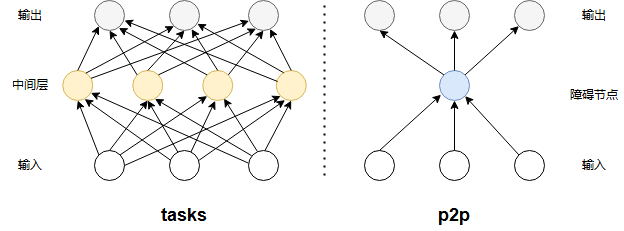

目前，Dask 提供了两类 Shuffle 实现策略：单机和分布式。

单机。如果数据大小超出了内存空间，可以将中间数据写到磁盘上。单机场景默认使用这种策略。

分布式。如 图 4.5 所示，分布式场景提供了两种 Shuffle 策略，tasks 和 p2p。tasks 是基于 Task Graph 的 Shuffle 实现，很多场景效率比较低，会遇到刚提到的 Task Graph 过大的问题。p2p 基于点对点的 Shuffle 实现，Task Graph 的复杂性显著降低，性能也显著提升。Dask 会优先选择 p2p。

`dask.config.set({"dataframe.shuffle.method": "p2p"})` 对当前 Python 脚本的所有计算都使用 p2p 方式进行 Shuffle。也可以针对某个算子设置 Shuffle 策略，比如 ddf.merge(shuffle_method="p2p")。

## 数据重分布

Dask DataFrame 提供了三种数据重分布方法：set_index()，repartition() 和 shuffle()，这三种都可能在全局层面对数据进行重分布。

|方法名|用途|是否修改索引|是否可以修改 Partition 数量|
|---|---|---|---|
|DataFrame.set_index()|修改索引列，加速后续基于索引列的计算|是|是|
|DataFrame.repartition()|修改 Partition 数量，多用于数据倾斜场景|否|是|
DataFrame.shuffle()|将相同的值归结到同一个 Partition|否|是|

我们提过，set_index() 将某字段设置为索引列，后续一系列计算非常依赖这个字段，set_index() 能显著加速后续计算。repartition() 主要解决数据倾斜的问题，即某些 Partiton 上的数据过大，过大的 Partition 有可能导致内存不足。

## groupby

我们以 groupby(by=key).sum() 为例，了解其背后的 Shuffle 过程。下图展示了计算过程，它主要有三个阶段：分组（Split）、组内聚合（Apply Aggregation，比如 sum）、组间聚合（Combine）。

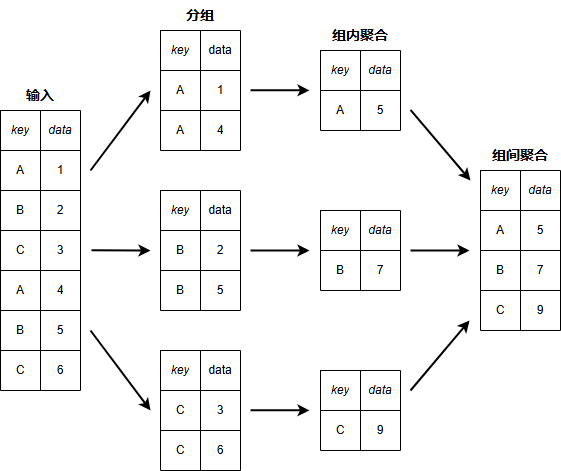

分布式场景下，不同的数据分布在不同的 Partition 下，涉及到 Shuffle 的阶段有：

- 分组：按照 by 指定的分组字段进行分组，相同的分组字段被分到一起，这里涉及到大量 Shuffle 操作。

- 组内聚合：组内聚合的 Shuffle 操作相对比较少。

- 组间聚合：组间聚合的 Shuffle 操作相对比较少。

根据 Shuffle 操作的数量，不难得出结论：

- groupby(by=indexed_columns).agg() 和 groupby(by=indexed_columns).apply(user_def_fn) 性能最好。indexed_columns 指的是分组字段 by 是索引列；agg 指的是 Dask DataFrame 提供的官方的 sum，mean 等聚合方法。因为 indexed_columns 是排过序的了，可以很快地对 indexed_columns 进行分组和数据分发。

- groupby(by=non_indexed_columns).agg() 的数据交换量要更大一些，Dask 官方提供的 agg 方法做过一些优化。

- groupby(by=non_indexed_columns).apply(user_def_fn) 的成本最高。它既要对所有数据进行交换，又要执行用户自定义的函数，用户自定义函数的效率比 Dask 官方的低。